In [147]:
import numpy as np
import pandas as pd
import inspect
import os
np.random.seed(0)

#Activation functions

def sin_function(x):
    return np.sin(x)

def sin_function_derivative(x):
    return np.cos(x)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x <= 0, 0, 1)

def tanh(x):
    return np.tanh(x)

def sech(x):
    return 1 / np.cosh(x)

def second_derivative_tanh(x):
    return -2 * (sech(x)**2) * np.tanh(x)

#Function to approximate
def f(x):
    return np.sin(3*np.pi*x + 3*np.pi/20) * np.cos(2*np.pi*x + np.pi/10) + 2

In [148]:
#Function to build the mass matrix - M
from scipy.integrate import quad

def mass_matrix(func,sigma, weights, biases, n):
    M = np.zeros([n, n])
    
    for i in range(0, n):
        for j in range(0, n):
            M[i, j] = quad(func, 0, 1, args=(weights, biases,i+1,j+1,sigma), limit=1000)[0]

    return M

In [149]:
#Single basis function - Neural Network
def single_neural_net(x,weights,biases,i, sigma): 

    return sigma(weights[i]*x+biases[i])


In [150]:
#Basis function multiplication helper for quadrature
def double_neural_net(x,weights,biases,i,j, sigma): 

    return single_neural_net(x,weights,biases,i,sigma)*single_neural_net(x,weights,biases,j,sigma)

In [151]:
#Bias helper function for quadrature
def b_neural_net(x, weights, biases,i, sigma,f):
    return single_neural_net(x,weights,biases,i, sigma)*f(x)


In [152]:
#quadrature for the bias matrix - B
def b_matrix(func,sigma, weights, biases,f, neurons):
    b = np.zeros([neurons, 1])
    for i in range(0, neurons):
            b[i] = quad(func, 0, 1, args=(weights, biases,i,sigma,f), limit=1000)[0]

    return b

In [153]:
#Function to build the approximation vector
def u_nn(x, weights, biases, sigma,collocation, neurons, a):
    u = np.zeros(collocation)
    
    for j in range(0,collocation):
        for i in range(0,neurons):
            
            u[j] += single_neural_net(x[j], weights, biases, i, sigma)*a[i]
        
    return u


In [154]:
#helper function for eigenvalues and eigenvectors
from scipy.linalg import eig
def get_eig(M):
    D,V = eig(M, left=False, right=True)


    idx = D.argsort()[::-1]   
    D = D[idx]
    V = V[:,idx]

    D = np.flip(D)
    V = np.fliplr(V)

    return D,V

In [155]:
#Function to calculate L2 loss
def l2_loss(f_x, u_nn_result):
    return np.linalg.norm(f_x - u_nn_result)**2

In [156]:
#Function to build the Phi matrix, made up of n basis functions
def phi_matrix(x,weights,biases,sigma,neurons,collocation):
    phi = np.zeros((collocation,neurons))
    for i in range(0,neurons):
        for j in range(0,collocation):

            phi[j,i] = sigma(weights[i]*x[j]+biases[i])
    return phi


In [157]:
def evaluate_func_approx(x,f, weights, biases, sigma, neurons, collocation,verbose=False):
    phi = phi_matrix(x,weights,biases,sigma,neurons,collocation)
    f_func = f(x)
    a = np.linalg.pinv(phi)@f_func

    u = u_nn(x, weights, biases, sigma, collocation,neurons, a)

    loss = l2_loss(f_func, u)
    if verbose:
        print("="*20)
        print("Sigma:", sigma.__name__)
        print("Number of collocation points:", collocation)
        print("Number of neurons:", neurons)
        print("L2 Loss:", loss)
        print("="*20)
    return loss

In [158]:
def export_list(data, list_name, sheet_name, directory=None, columns=None, overwrite=False):
    default_directory = '/mnt/c/Git_Repos/Function_approximation/Results'
    file_name = f"{list_name}.xlsx"
    
    if columns is None:
        columns = ["Loss", "# of Collocation", "# of Neurons", "Activation Function", "R - Sample Range"]
    
    if directory is None:
        directory = default_directory
    
    full_path = os.path.join(directory, file_name)
    df = pd.DataFrame(data, columns=columns)

    if os.path.exists(full_path):
        try:
            # If the file exists
            with pd.ExcelWriter(full_path, engine='openpyxl', mode='a') as writer:
                if overwrite:
                    # If overwrite is True, delete the sheet if it exists
                    if sheet_name in writer.book.sheetnames:
                        writer.book.remove(writer.book[sheet_name])
                # Write the DataFrame to the Excel file
                df.to_excel(writer, sheet_name=sheet_name, index=False)
        except ValueError as e:
            # If the sheet already exists and overwrite is False, print a message and continue
            print(f"Sheet name '{sheet_name}' already exists in the file '{file_name}'")
    else:
        # If the file does not exist, create a new one
        df.to_excel(full_path, index=False, sheet_name=sheet_name)

    print(f"Data exported to {full_path}")

In [159]:
def compute_loss_values(neurons, collocations, sigmas, Rs, sheet_name, xmin=0, xmax=1, overwrite=False, verbose=False):
    loss_values = []
    #np.random.seed(0)  # Set a seed for reproducibility
    for sigma in sigmas:
        for neuron in neurons:
            for collocation in collocations:
                for R in Rs:
                    x = np.linspace(xmin, xmax, collocation)
                    weights = np.random.uniform(-R, R, neuron)
                    biases = np.random.uniform(-R, R, neuron)
                    loss = evaluate_func_approx(x, f, weights, biases, sigma, neuron, collocation, verbose=verbose)
                    loss_values.append((loss, collocation, neuron, sigma.__name__,R))  # Add activation function name
    export_list(loss_values, "Finite_Neuron_Method_Results", sheet_name, overwrite=overwrite)
    return loss_values

In [160]:
def print_loss_by_collocation(loss_values):
    """
    Prints the loss values grouped by collocation point, activation function, and range R.
    
    Parameters:
    loss_values (list of tuples): Each tuple contains (loss, collocation, neuron, activation_func_name, R).
    """
    # Initialize the dictionary to store data for each collocation point
    collocation_loss_data = {collocation: [] for _, collocation, _, _, _ in loss_values}

    # Populate the dictionary with (neuron, loss, activation_func_name, R) tuples for each collocation point
    for loss, collocation, neuron, activation_func_name, R in loss_values:
        collocation_loss_data[collocation].append((neuron, loss, activation_func_name, R))

    # Iterate over the unique activation function names
    for activation_func_name in set(activation_func_name for _, _, _, activation_func_name, _ in loss_values):
        print(f"Activation Function: {activation_func_name}")
        
        # Iterate over the collocation points and print the relevant data
        for collocation, data in collocation_loss_data.items():
            print(f"# of Collocation points: {collocation}")
            
            # Print the neurons, loss values, and R for the current activation function
            for neuron, loss, act_func_name, R in data:
                if act_func_name == activation_func_name:
                    print(f"  # of Neurons: {neuron}, Loss: {loss:.10e}, R: {R}")



In [161]:
def print_loss_by_neuron(loss_values):
    """
    Prints the loss values grouped by neuron, activation function, and range R.
    
    Parameters:
    loss_values (list of tuples): Each tuple contains (loss, collocation, neuron, activation_func_name, R).
    """
    # Initialize the dictionary to store data for each neuron
    neuron_loss_data = {neuron: [] for _, _, neuron, _, _ in loss_values}

    # Populate the dictionary with (collocation, loss, activation_func_name, R) tuples for each neuron
    for loss, collocation, neuron, activation_func_name, R in loss_values:
        neuron_loss_data[neuron].append((collocation, loss, activation_func_name, R))

    # Iterate over the unique activation function names
    for activation_func_name in set(activation_func_name for _, _, _, activation_func_name, _ in loss_values):
        print(f"Activation Function: {activation_func_name}")
        
        # Iterate over the neurons and print the relevant data
        for neuron, data in neuron_loss_data.items():
            print(f"# of Neurons: {neuron}")
            
            # Print the collocation points, loss values, and R for the current activation function
            for collocation, loss, act_func_name, R in data:
                if act_func_name == activation_func_name:
                    print(f"  # of Collocation points: {collocation}, Loss: {loss:.10e}, R: {R}")




In [162]:
def print_loss_by_R(loss_values):
    """
    Prints the loss values grouped by the range R, activation function, collocation points, and neurons.
    
    Parameters:
    loss_values (list of tuples): Each tuple contains (loss, collocation, neuron, activation_func_name, R).
    """
    # Initialize the dictionary to store data for each R value
    R_loss_data = {R: [] for _, _, _, _, R in loss_values}

    # Populate the dictionary with (collocation, neuron, loss, activation_func_name) tuples for each R value
    for loss, collocation, neuron, activation_func_name, R in loss_values:
        R_loss_data[R].append((collocation, neuron, loss, activation_func_name))

    # Iterate over the unique activation function names
    for activation_func_name in set(activation_func_name for _, _, _, activation_func_name, _ in loss_values):
        print(f"Activation Function: {activation_func_name}")
        
        # Iterate over the R values and print the relevant data
        for R, data in R_loss_data.items():
            print(f"Range R: {R}")
            
            # Print the collocation points, neurons, and loss values for the current activation function
            for collocation, neuron, loss, act_func_name in data:
                if act_func_name == activation_func_name:
                    print(f"  # of Collocation points: {collocation}, # of Neurons: {neuron}, Loss: {loss:.10e}")

In [163]:
collocation = 50
neurons = 25
sigma = sin_function
x = np.linspace(0,1,collocation)
weights = np.random.uniform(-5,5,neurons)
biases = np.random.uniform(-5,5,neurons)
test = evaluate_func_approx(x,f, weights, biases, sigma, neurons, collocation,verbose=True)

Sigma: sin_function
Number of collocation points: 50
Number of neurons: 25
L2 Loss: 1.8921620734168687e-05


# Test 1 - Increasing #of neurons
Keeping collocations fixed at 50, and using ReLU, tanh, and sin as activation functions

In [164]:
neurons = [5,10,20,30,40,50,100]
sigmas = [relu_derivative,second_derivative_tanh,sin_function_derivative]
collocations = [50]
Rs = [1]
loss_values = compute_loss_values(neurons, collocations, sigmas, Rs, "Increasing # of Neurons", overwrite=False, verbose=False)
#print_loss_by_R(loss_values_increasing_neurons)
#loss_values

Sheet name 'Increasing # of Neurons' already exists in the file 'Finite_Neuron_Method_Results.xlsx'
Data exported to /mnt/c/Git_Repos/Function_approximation/Results/Finite_Neuron_Method_Results.xlsx


/home/zephunix/miniconda3/envs/tf/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


# Test 2 - Increasing Collocation points
Keeping neurons fixed at 20, and the same activation functions

In [165]:
neurons = [20]
sigmas = [relu_derivative,second_derivative_tanh,sin_function_derivative]
collocations = [10,50,100,200,500]
Rs = [1]
loss_values = compute_loss_values(neurons, collocations,sigmas,Rs,"Increasing # of Collocation Points",overwrite=True,verbose=False)

Data exported to /mnt/c/Git_Repos/Function_approximation/Results/Finite_Neuron_Method_Results.xlsx


/home/zephunix/miniconda3/envs/tf/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


In [166]:
import pandas as pd

# Convert list to DataFrame
df = pd.DataFrame(loss_values, columns=['Loss', 'Collocation', 'Neurons', 'Activation Function', 'R'])

# Sort DataFrame by 'Loss' column
sorted_df = df.sort_values(by='Loss')

print("Sorted by Loss")
print(sorted_df)
print("="*80)
print("")
print("Filtered for Sin Activation Function")
filtered_df = df[df["Activation Function"] == "sin_function"]

print(filtered_df)

Sorted by Loss
            Loss  Collocation  Neurons      Activation Function  R
5   1.545222e-18           10       20   second_derivative_tanh  1
7   2.840159e-06          100       20   second_derivative_tanh  1
8   3.850406e-05          200       20   second_derivative_tanh  1
6   1.350297e-04           50       20   second_derivative_tanh  1
10  1.397026e-04           10       20  sin_function_derivative  1
9   1.877048e-04          500       20   second_derivative_tanh  1
11  4.587796e-02           50       20  sin_function_derivative  1
12  7.949781e-02          100       20  sin_function_derivative  1
13  1.585435e-01          200       20  sin_function_derivative  1
14  3.875012e-01          500       20  sin_function_derivative  1
0   1.255388e+00           10       20          relu_derivative  1
1   4.544093e+00           50       20          relu_derivative  1
2   1.130951e+01          100       20          relu_derivative  1
3   2.402990e+01          200       20         

In [167]:
#print_loss_by_neuron(loss_values)

# Test 3 - Increasing the sampling range R
Keeping neurons and collocations fixed, increasing R to increase chance that w_i and b_i are further away from w_j and b_j

In [168]:
neurons = [30]
sigmas = [tanh,relu,sin_function]
sigmas_derivative = [second_derivative_tanh,relu_derivative,sin_function_derivative]
collocations = [50]
Rs = [1,2,4,5,10]
loss_values = compute_loss_values(neurons, collocations,sigmas,Rs,"Increasing R",overwrite=True,verbose=False)
derivative_loss_values = compute_loss_values(neurons, collocations,sigmas_derivative,Rs,"Increasing R - Derivative activations",overwrite=True,verbose=False)

/home/zephunix/miniconda3/envs/tf/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
/home/zephunix/miniconda3/envs/tf/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


Data exported to /mnt/c/Git_Repos/Function_approximation/Results/Finite_Neuron_Method_Results.xlsx
Data exported to /mnt/c/Git_Repos/Function_approximation/Results/Finite_Neuron_Method_Results.xlsx


In [169]:
comparison_values = loss_values + derivative_loss_values
df = pd.DataFrame(comparison_values, columns=["Loss", "# of Collocation", "# of Neurons", "Activation Function", "R - Sample Range"])

# Export the DataFrame to an Excel file
df.to_excel("combined_loss_values.xlsx", index=False)

print("Data exported to combined_loss_values.xlsx")

Data exported to combined_loss_values.xlsx


In [170]:
#print_loss_by_collocation(derivative_loss_values)

In [171]:
function_dict = {(func, r): err for err, _, _, func, r in loss_values}
derivative_dict = {(func, r): err for err, _, _, func, r in derivative_loss_values}

def base_function_name(derivative_name):
    if derivative_name.endswith('_derivative'):
        return derivative_name.replace('_derivative', '')
    return None

comparison_results = []
for (func_name, r), err in derivative_dict.items():
    base_name = base_function_name(func_name)
    if base_name:
        base_err = function_dict.get((base_name, r))
        if base_err is not None:
            comparison_results.append((base_name, r, base_err, err))

print(f"{'Function':<20}{'R Value':<10}{'Function Error':<20}{'Derivative Error':<25}")
print("="*80)
for base_name, r, base_err, der_err in comparison_results:
    print(f"{base_name:<20}{r:<10}{base_err:<20.10e}{der_err:<25.10e}")


Function            R Value   Function Error      Derivative Error         
relu                1         1.6664041102e+00    2.7660848193e+00         
relu                2         3.4714710352e+00    2.8275555731e+00         
relu                4         9.9038903483e-01    3.5420412097e+00         
relu                5         4.5714110498e+00    2.6294365201e+00         
relu                10        4.4151250080e+00    3.3007514858e+00         
sin_function        1         4.5363940284e-02    4.8811810505e-02         
sin_function        2         9.5150452829e-04    9.0140079961e-04         
sin_function        4         1.4102461895e-05    7.2418770415e-06         
sin_function        5         5.2211838333e-06    6.1800099832e-04         
sin_function        10        3.4484461669e-06    1.4430549844e-04         


In [172]:
neurons = [10,20,30,50,100]
sigmas = [tanh,relu,sin_function]
collocations = [5,10,30,50,100]
Rs = [1,2,4,5,10]
loss_values = compute_loss_values(neurons, collocations,sigmas,Rs,"Full_tests",overwrite=True,verbose=False)

Data exported to /mnt/c/Git_Repos/Function_approximation/Results/Finite_Neuron_Method_Results.xlsx


/home/zephunix/miniconda3/envs/tf/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


In [173]:
#print_loss_by_collocation(loss_values)

# Building Mass matrix

In [174]:
from scipy.integrate import quad

def mass_matrix(func,sigma, weights, biases, neurons):
    M = np.zeros([neurons, neurons])
    
    for i in range(0, neurons):
        for j in range(0, neurons):
            M[i, j] = quad(func, 0, 1, args=(weights, biases,i,j,sigma), limit=1000)[0]

    return M

In [182]:
import matplotlib.pyplot as plt
def create_linear_system(x, neurons, collocation, weights, biases, sigma, f):

    M = mass_matrix(double_neural_net,sigma, weights, biases, neurons)
    b = b_matrix(b_neural_net,sigma,weights, biases,f,neurons).squeeze()
    a = np.linalg.solve(M,b)
    u = u_nn(x,weights,biases,sigma,collocation,neurons,a)
    
    loss = l2_loss(f(x), u)
    print("="*80)
    print(f"Neurons: {neurons}, Collocation: {collocation}")
    print("L2 Loss:", loss)


    plt.plot(x, u, label=f'u(x), neurons={neurons}, collocation={collocation}')
    plt.legend()

    return M, b, a, u, loss


In [176]:
neurons = 70
collocation = 50
x = np.linspace(0,1,collocation)
R = 10
weights = np.random.uniform(-R,R,neurons)
biases = np.random.uniform(-R,R,neurons)
sigma = second_derivative_tanh
M = mass_matrix(double_neural_net,sigma, weights, biases, neurons)

Neurons: 70, Collocation: 50
L2 Loss: 4.63907634487278e-06


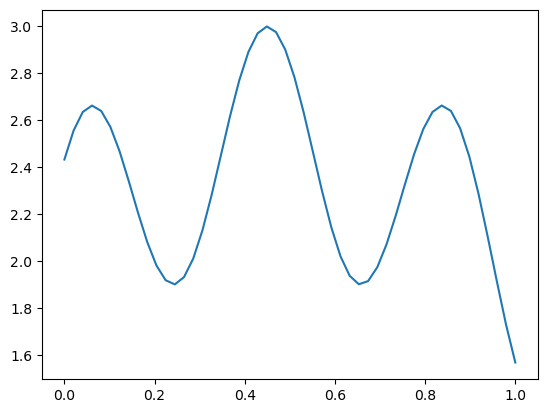

In [177]:
M, b, a, u ,loss= create_linear_system(x, neurons, collocation, weights, biases, sigma, f)

Neurons: 10, Collocation: 50
L2 Loss: 0.09061567296338507
Neurons: 20, Collocation: 50
L2 Loss: 6.000507240183578e-05
Neurons: 50, Collocation: 50
L2 Loss: 1.0759555110838817e-06
Neurons: 100, Collocation: 50
L2 Loss: 4.151570762287593e-08


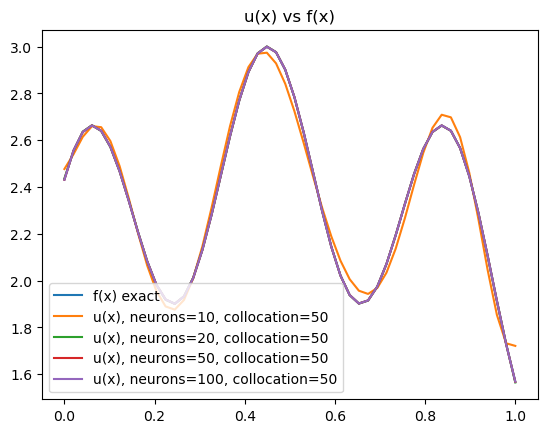

In [184]:
# Example usage
sigma = second_derivative_tanh  # Activation function
neuron_counts = [10, 20,50,100]
collocation = 50
x = np.linspace(0, 1, collocation)

losses= []
results = []

# Plot the exact solution once
plt.plot(x, f(x), label='f(x) exact', )
plt.title("u(x) vs f(x)")

for neuron in neuron_counts:
    weights = np.random.uniform(-5, 5, neuron)
    biases = np.random.uniform(-5, 5, neuron)
    M,b,a,u,loss = create_linear_system(x, neuron, collocation, weights, biases, sigma, f)
    losses.append(loss)
    results.append([M,b,a,u,loss])
    
#plt.legend()

In [189]:
results[0][0] # M matrix for 10 neurons
results[0][1] # b matrix for 10 neurons
results[0][2] # a matrix for 10 neurons
results[0][3] # u matrix for 10 neurons

array([2.47694784, 2.54085292, 2.61480133, 2.660197  , 2.65578079,
       2.59635127, 2.48954136, 2.35158068, 2.20297028, 2.06472878,
       1.95552185, 1.88970378, 1.87614278, 1.9176664 , 2.01100866,
       2.14721642, 2.31253434, 2.48980277, 2.66035119, 2.80625323,
       2.91265765, 2.96978107, 2.97411701, 2.92853734, 2.84123362,
       2.72378603, 2.58891967, 2.4485858 , 2.31284358, 2.18968258,
       2.08556205, 2.00619507, 1.95705701, 1.943243  , 1.968566  ,
       2.03408011, 2.13644938, 2.26670511, 2.40992139, 2.54619149,
       2.65302849, 2.70898464, 2.69794596, 2.61328884, 2.46096595,
       2.26068152, 2.04463791, 1.85383225, 1.73243487, 1.72123547])

Neurons: 10, Collocation: 50
L2 Loss: 0.18162338501196262
Neurons: 20, Collocation: 50
L2 Loss: 0.02283746295282828
Neurons: 50, Collocation: 50
L2 Loss: 3.68324306789696e-07
Neurons: 100, Collocation: 50
L2 Loss: 1.0968616057156561e-08


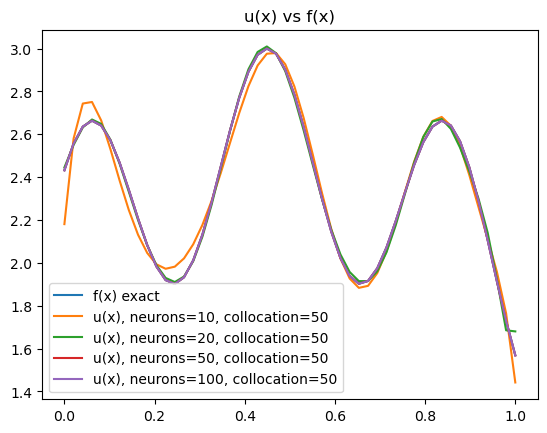

In [179]:
sigma = second_derivative_tanh  # Activation function
neuron_counts = [10, 20,50,100]
collocation = 50
x = np.linspace(0, 1, collocation)

losses= []

# Plot the exact solution once
plt.plot(x, f(x), label='f(x) exact')
plt.title("u(x) vs f(x)")


for neuron in neuron_counts:
    weights = np.random.uniform(-5, 5, neuron)
    biases = np.random.uniform(-5, 5, neuron)
    _,_,_,_,loss = create_linear_system(x, neuron, collocation, weights, biases, sigma, f)
    losses.append(loss)
    
plt.legend()